# Convolutional Neural Networks

이번에는 이미지 인식 분야에서 가장 성공적으로 쓰이고 있는 Convolutional Neural Networks를 실습해본다.  
Convolutional Neural Networks, CNN은 아래와 같은 Convolutional Layer를 여러층 가진 딥러닝 모델을 뜻한다.


이번에는 간단한 구조를 가진 CNN을 구현한다.
MNIST 데이터를 이용하여 학습하고 테스팅 해본다. 

사용된 기술

- conv2d
- max-pool
- weight 초기화: truncated normal dist.
- RMSProp optimizer

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import time

- one epoch에 55,000장의 이미지중 랜덤하게 128개를 선택해서 사용 한다.
- 메모리 문제로 10,000개의 testing image중에서 랜덤 shuffling을 한 후에 200개를 선택해서 사용 한다.

In [2]:
batch_size = 125
test_size = 200
training_epochs = 20

**구현 하는 Network**
<img src = 'mycnn.JPG'>
(출처: 직접 그림)

In [4]:
def init_weights(shape):
    #return tf.Variable(tf.random_normal(shape, stddev=0.01))
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

# Filter weight vectors 또는 kernel: w, w2, w3, w4, w_0
def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
        
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)


    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)


    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)


    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)

    pyx = tf.matmul(l4, w_o)
    return pyx

# Read data
mnist = input_data.read_data_sets("MNIST_DATA/", one_hot=True)
#trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

# trx.reshape( n-inputs, image size, image size, depth )
 # this variable is input in model()
#trX = trX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
#teX = teX.reshape(-1, 28, 28, 1)  # 28x28x1 input img

X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 10])         # FC 625 inputs, 10 outputs (labels)

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")

py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

init = tf.global_variables_initializer()

# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    start_time = time.time()
    sess.run(init)

    for i in range(training_epochs):
        avg_cost = 0.
        avg_training_accuracy = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
              
        for step in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            batch_xs_image = batch_xs.reshape(-1, 28, 28, 1)
            
            sess.run(train_op, feed_dict={X: batch_xs_image, Y: batch_ys,
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})
            # Training average cost 계산
            avg_cost += sess.run(cost, feed_dict={X: batch_xs_image, Y: batch_ys, p_keep_conv:1.0, p_keep_hidden:1.0})/total_batch
            
            avg_training_accuracy += (np.mean(np.argmax(batch_ys, axis=1) ==
                         sess.run(predict_op, feed_dict={X: batch_xs_image,
                                                        Y: batch_ys,
                                                        p_keep_conv: 1.0,
                                                        p_keep_hidden: 1.0})))/total_batch
            
        print("Epoch: %d, training error: %.4f, training accuracy: %.4f"%(i,avg_cost,avg_training_accuracy))

        # testing accuracy 계산
        # 인덱스를 뒤 썩어 준다. 랜덤하게 200개 추출을 위해서
        test_indices = np.arange(mnist.test.labels.shape[0]) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size] # 200개만 선택한다. 
        teX = mnist.test.images[test_indices].reshape(-1, 28, 28, 1) # input을 2차원 image를 담은 3차원 matrix로 표현 
        testing_accuracy = np.mean(np.argmax(mnist.test.labels[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX,
                                                        Y: mnist.test.labels[test_indices],
                                                        p_keep_conv: 1.0,
                                                        p_keep_hidden: 1.0}))
        print("Testing Accuracy: %.4f"%(testing_accuracy))
        
        # shuffled testing data 200개에 대해서 accuracy 1.0에 도달하면 Training을 멈춘다.
        if testing_accuracy == 1.0:
            print("Early stop..")
            break
        
    print("time elapsed: {:.2f}s".format(time.time() - start_time))

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz
Epoch: 0, training error: 0.6364, training accuracy: 0.8153
Testing Accuracy: 0.9700
Epoch: 1, training error: 0.0272, training accuracy: 0.9928
Testing Accuracy: 0.9900
Epoch: 2, training error: 0.0138, training accuracy: 0.9966
Testing Accuracy: 0.9800
Epoch: 3, training error: 0.0104, training accuracy: 0.9973
Testing Accuracy: 0.9950
Epoch: 4, training error: 0.0080, training accuracy: 0.9980
Testing Accuracy: 0.9950
Epoch: 5, training error: 0.0064, training accuracy: 0.9986
Testing Accuracy: 0.9900
Epoch: 6, training error: 0.0052, training accuracy: 0.9988
Testing Accuracy: 0.9900
Epoch: 7, training error: 0.0046, training accuracy: 0.9990
Testing Accuracy: 0.9900
Epoch: 8, training error: 0.0043, training accuracy: 0.9989
Testing Accuracy: 0.9900
Epoch: 9, training error: 0.0037, trainin

In [3]:
# Read data
mnist = input_data.read_data_sets("MNIST_DATA/", one_hot=True)
batch_xs, batch_ys = mnist.train.next_batch(batch_size)

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [5]:
batch_xs.shape

(100, 784)

In [24]:
mnist.test.labels.shape[0]

10000

In [26]:
test_indices = np.arange(mnist.test.labels.shape[0]) # Get A Test Batch
#np.random.shuffle(test_indices)
test_indices

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [7]:
total_batch = int(mnist.train.num_examples/batch_size)
total_batch

550

In [58]:
mnist.test.labels[0:200]

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]])

In [62]:
np.argmax(mnist.test.labels[0:200], axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6,
       5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5,
       1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3,
       0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6,
       9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7,
       4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1,
       6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4,
       6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0,
       8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2])

In [63]:
np.argmax(mnist.test.labels[test_indices], axis=1)

array([0, 1, 7, 6, 6, 9, 5, 6, 6, 9, 9, 0, 6, 6, 6, 4, 0, 4, 4, 9, 9, 2, 0,
       0, 0, 4, 5, 9, 8, 6, 2, 9, 3, 9, 2, 2, 6, 1, 7, 3, 3, 3, 8, 6, 7, 6,
       9, 7, 9, 8, 0, 6, 0, 3, 7, 9, 5, 8, 2, 1, 1, 6, 6, 5, 8, 1, 3, 4, 5,
       4, 8, 6, 7, 3, 5, 5, 1, 7, 1, 1, 0, 0, 5, 1, 2, 2, 3, 6, 9, 6, 8, 4,
       6, 8, 0, 5, 4, 8, 8, 2, 7, 9, 7, 0, 6, 9, 8, 6, 9, 4, 7, 9, 4, 4, 4,
       4, 6, 7, 1, 7, 3, 8, 0, 9, 5, 9, 4, 5, 1, 8, 4, 7, 8, 0, 9, 3, 2, 7,
       3, 1, 9, 4, 1, 9, 1, 4, 2, 5, 1, 8, 3, 9, 1, 4, 9, 7, 7, 1, 6, 9, 5,
       3, 6, 0, 7, 1, 4, 8, 9, 3, 8, 5, 8, 2, 0, 7, 4, 8, 6, 0, 3, 4, 3, 0,
       2, 3, 3, 1, 8, 5, 4, 3, 1, 1, 1, 2, 4, 7, 7, 6])

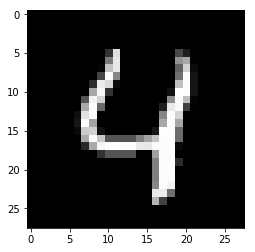

In [20]:
plt.imshow(mnist.test.images[4].reshape(28,28), cmap="gray", interpolation="nearest")
plt.show()

In [37]:
batch_xs, batch_ys = mnist.train.next_batch(batch_size)
X_image = tf.reshape(batch_xs, [-1,28,28,1])

In [7]:
training_batch = zip(range(0, 50000, 128),
                     range(128, 50000+1, 128))
training_batch

In [8]:
batch = 128
for i,j in training_batch:
    print(i,j)

0 128
128 256
256 384
384 512
512 640
640 768
768 896
896 1024
1024 1152
1152 1280
1280 1408
1408 1536
1536 1664
1664 1792
1792 1920
1920 2048
2048 2176
2176 2304
2304 2432
2432 2560
2560 2688
2688 2816
2816 2944
2944 3072
3072 3200
3200 3328
3328 3456
3456 3584
3584 3712
3712 3840
3840 3968
3968 4096
4096 4224
4224 4352
4352 4480
4480 4608
4608 4736
4736 4864
4864 4992
4992 5120
5120 5248
5248 5376
5376 5504
5504 5632
5632 5760
5760 5888
5888 6016
6016 6144
6144 6272
6272 6400
6400 6528
6528 6656
6656 6784
6784 6912
6912 7040
7040 7168
7168 7296
7296 7424
7424 7552
7552 7680
7680 7808
7808 7936
7936 8064
8064 8192
8192 8320
8320 8448
8448 8576
8576 8704
8704 8832
8832 8960
8960 9088
9088 9216
9216 9344
9344 9472
9472 9600
9600 9728
9728 9856
9856 9984
9984 10112
10112 10240
10240 10368
10368 10496
10496 10624
10624 10752
10752 10880
10880 11008
11008 11136
11136 11264
11264 11392
11392 11520
11520 11648
11648 11776
11776 11904
11904 12032
12032 12160
12160 12288
12288 12416
12416 1254

In [14]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])